# Trabajo Practico N° 2
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini


In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.outliers import Winsorizer 

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

#KNN
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error)

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay, classification_report)

In [85]:
def tableResult(label, prediction):
    table = pd.DataFrame({'Actual':label, 'Predicted':prediction})
    return table

# Primer dataset

## Análisis exploratorio de datos (EDA)

In [86]:
dataset1 = pd.read_csv('1000_Companies.csv')

In [87]:
#Creamos copia del dataset original
df1 = dataset1.copy()

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [88]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [89]:
df1.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


**Análisis de la variable y**

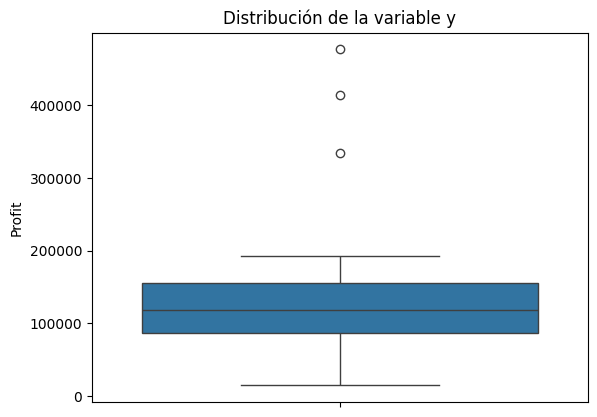

In [90]:
plt.title('Distribución de la variable y')
sns.boxplot(df1['Profit']);

Se notó que la variable *y* presentaba outliers

In [91]:
df1[df1['Profit'] > 300000]

,RyD_Spend,Administration,MarketingSpend,State,Profit
997,100275.47,241926.31,227142.82,California,413956.48
998,128456.23,321652.14,281692.32,California,333962.19
999,161181.72,270939.86,295442.17,New York,476485.43


In [92]:
df1 = df1[df1['Profit'] < 300000]

Se eliminaron los 3 outliers, porque estos se alejaban mucho de la mediana

**Valores duplicados**

In [93]:
df1.duplicated().values.any()

True

In [94]:
df1 = df1.drop_duplicates()

**Valores faltantes**

In [95]:
df1.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

**Codificación de variables catgorícas**

In [96]:
df1 = pd.get_dummies(data=df1, columns=['State'])

cols_bool = ['State_California', 'State_Florida', 'State_New York']
df1[cols_bool] = df1[cols_bool].astype('int')

df1

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.8000,471784.1000,192261.83000,0,0,1
1,162597.70,151377.5900,443898.5300,191792.06000,1,0,0
2,153441.51,101145.5500,407934.5400,191050.39000,0,1,0
3,144372.41,118671.8500,383199.6200,182901.99000,0,0,1
4,142107.34,91391.7700,366168.4200,166187.94000,0,1,0
...,...,...,...,...,...,...,...
992,105127.00,125982.7298,271621.8728,138841.98810,0,1,0
993,46798.00,117368.4374,159075.9080,89012.02672,1,0,0
994,97209.00,124813.3635,256344.0701,132077.70900,0,0,1
995,54135.00,118451.9990,173232.6695,95279.96251,1,0,0


In [97]:
X1 = df1.drop(columns=['Profit'])
y1 = df1['Profit']

In [98]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=13)
X_train4, X_test4, y_train4, y_test4  = train_test_split(X1, y1, test_size=0.3, random_state=13)

**Distribuciones  y correlaciones de las variables**

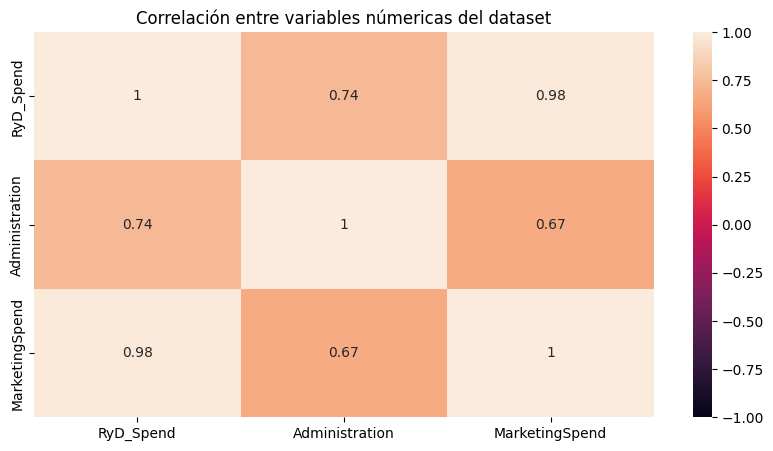

In [99]:
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

plt.figure(figsize=(10,5))
sns.heatmap(X_train1[columnas_numericas].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

A partir del gráfico se observa que las variables numéricas del dataset presentan únicamente correlaciones positivas. La variable RyD_Spend presenta una fuerte correlación positiva con Administration de 0.74, y además tiene la correlación más fuerte de 0.98 con con MarketingSpend.

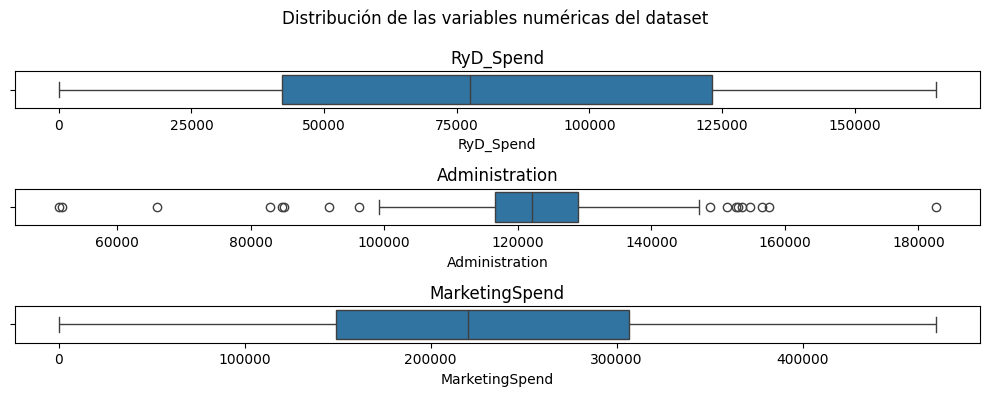

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=X_train1[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que:
* Las variables RyD_Spend y MarketingSpend no presentan valores atípicos.
* La variable Administration presenta valores atípicos, que decidimos filtrar.

**Outliers**

In [101]:
# Primer dataset (80,20)
winsor = Winsorizer(capping_method='iqr', tail='both',fold=3)

X_train1[columnas_numericas] = winsor.fit_transform(X_train1[columnas_numericas])
X_test1[columnas_numericas] = winsor.transform(X_test1[columnas_numericas])

# Segundo dataset (70,20)
winsor2 = Winsorizer(capping_method='iqr', tail='both',fold=3)

X_train4[columnas_numericas] = winsor2.fit_transform(X_train4[columnas_numericas])
X_test4[columnas_numericas] = winsor2.transform(X_test4[columnas_numericas])

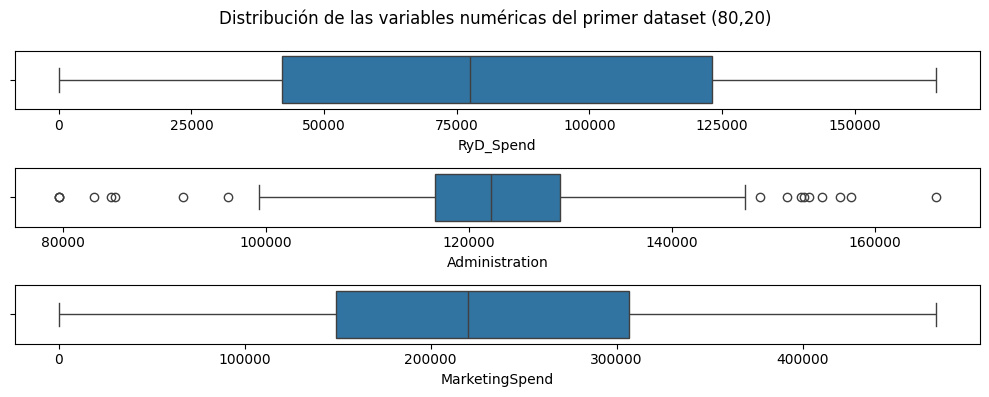

In [102]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=False, figsize=(10, 4))

for i, col in enumerate(columnas_numericas, 1):
    sns.boxplot(data=X_train1, x=col, ax=axes.flatten()[i-1])

for i in range(4, 4):
    axes.flatten()[i-1].axis('off')

fig.suptitle('Distribución de las variables numéricas del primer dataset (80,20)')
plt.tight_layout()
plt.show()

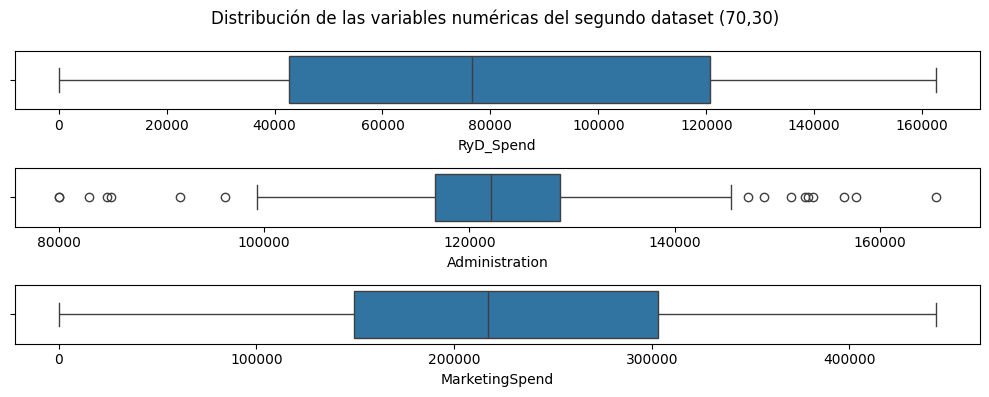

In [103]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=False, figsize=(10, 4))

for i, col in enumerate(columnas_numericas, 1):
    sns.boxplot(data=X_train4, x=col, ax=axes.flatten()[i-1])

for i in range(4, 4):
    axes.flatten()[i-1].axis('off')

fig.suptitle('Distribución de las variables numéricas del segundo dataset (70,30)')
plt.tight_layout()
plt.show()

## Árbol de decisión

**Modelo base**

In [104]:
modelo_base1 = DecisionTreeRegressor(max_depth=None)

modelo_base1.fit(X_train1, y_train1);

Definimos un modelo base dejando max_depth=None para que el árbol crezca completamente, para después compararlo con el modelo optimizado y analizar cómo se realiza la poda.

**Optimización del árbol**

In [105]:
param_grid = {
    'max_depth': [5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 5, 7, 10],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
}

modelo_semilla = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(modelo_semilla, param_distributions=param_grid, random_state=42)
random_search.fit(X_train1, y_train1)

# Guardamos los mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
print(f'{first_best_params}')

{'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 15, 'criterion': 'squared_error'}


**Mejor modelo**

In [106]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_reg = DecisionTreeRegressor(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13)

### Dataset 1 (80, 20)

In [107]:
tree_reg.fit(X_train1, y_train1)

,criterion,'squared_error'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [108]:
pred_train = tree_reg.predict(X_train1)

pred_test = tree_reg.predict(X_test1)

tableResult(y_test1, pred_test).head(5)

,Actual,Predicted
206,159509.00490,159029.429027
780,144130.05170,143795.413543
417,80082.11902,80284.586073
870,50428.81124,44071.062999
988,83178.92524,84323.281386


### Visualización

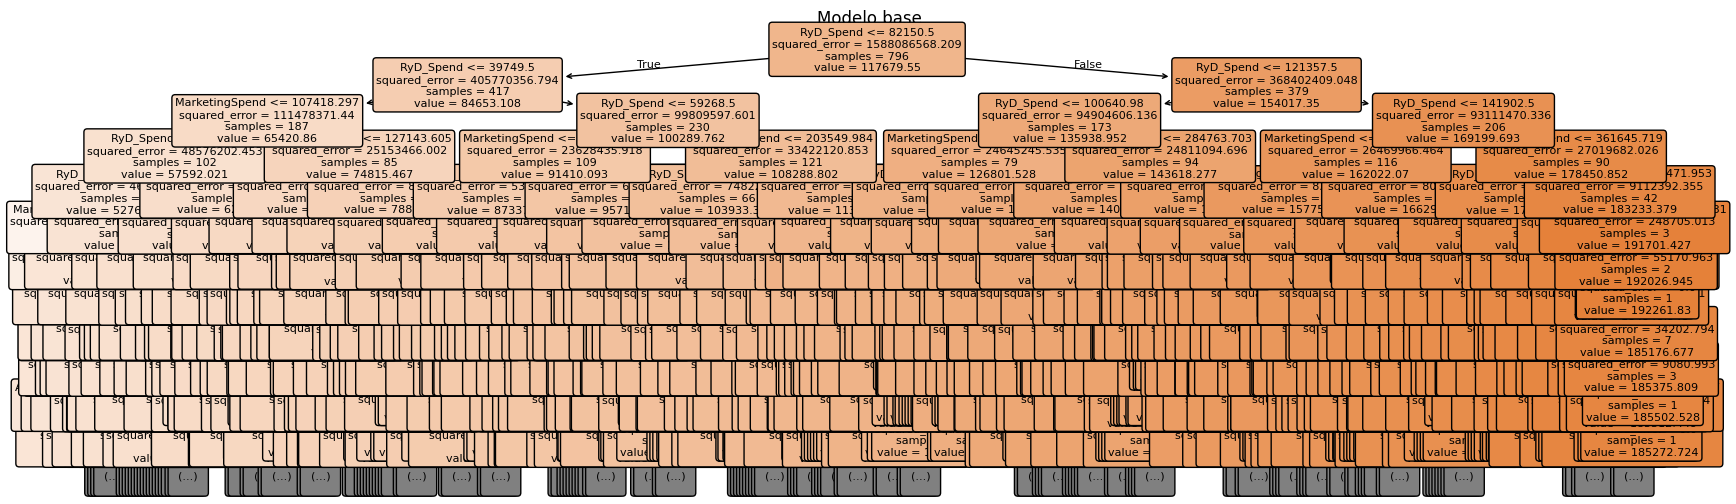

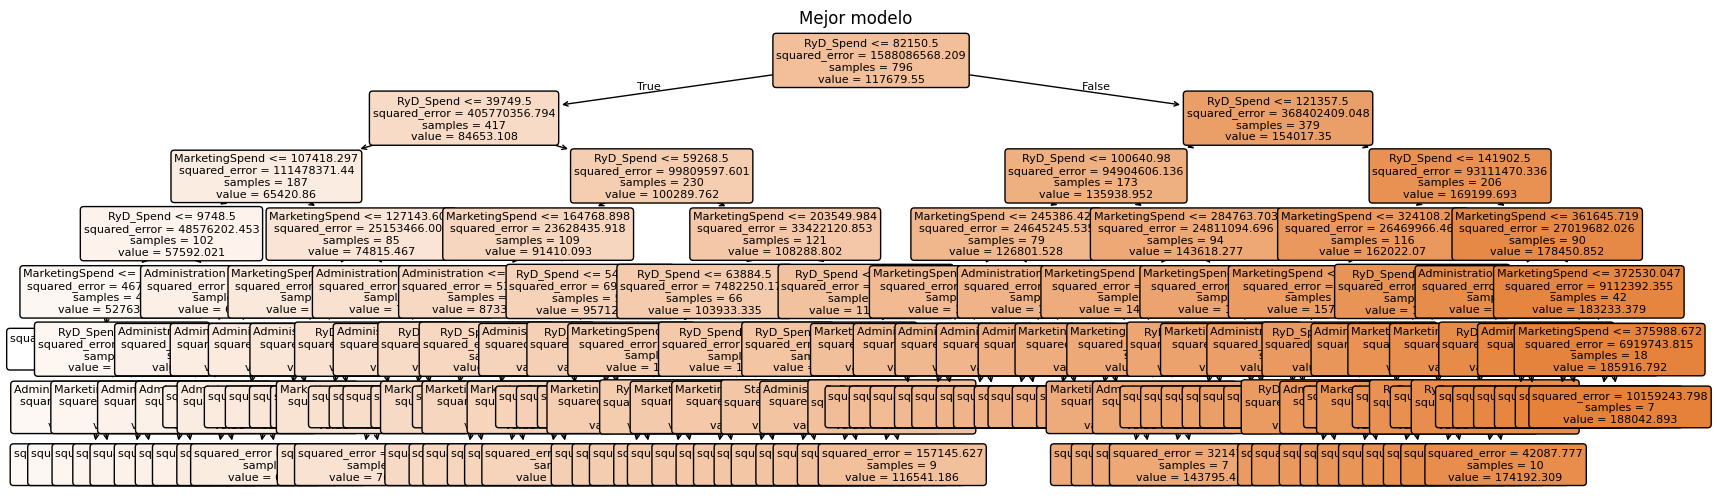

In [109]:
# Modelo base
plt.figure(figsize=(20,6))
plot_tree(modelo_base1, feature_names=X_train1.columns, fontsize=8, filled=True, rounded=True, max_depth=11)
plt.title('Modelo base')  
plt.show()

# Mejor modelo
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train1.columns, fontsize=8, filled=True, rounded=True, max_depth=11)
plt.title('Mejor modelo') 
plt.show()

In [110]:
# Obtenemos las profundidades de los árboles  
profundidad_modelo_base1 = modelo_base1.get_depth()
profundidad_tree_reg = tree_reg.get_depth()

print(f'profundidad del modelo base: {profundidad_modelo_base1}')
print(f'profundidad del mejor modelo: {profundidad_tree_reg}')

profundidad del modelo base: 14
profundidad del mejor modelo: 7


A partir de la comparación entre los dos árboles de decisión de los modelos, podemos notar una mejora en el segundo modelo debido a que se realizó una poda, donde se reduce a la mitad la longitud del árbol, evitando overfitting.

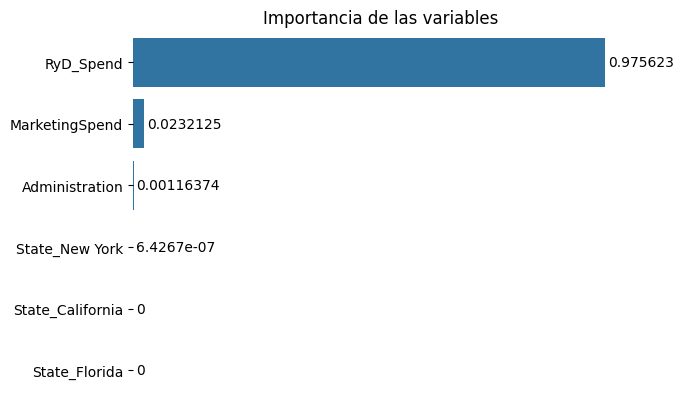

In [111]:
features_df = pd.DataFrame({'features': X_train1.columns, 'importances': tree_reg.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 4 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [112]:
rmse1 = np.sqrt(mean_squared_error(y_test1, pred_test))

print('Error absoluto medio (MAE):', mean_absolute_error(y_test1, pred_test))
print('Error medio cuadrado (MSE):', mean_squared_error(y_test1, pred_test))
print('Raíz del error medio cuadrado (RMSE):', rmse1)
print("Porcentaje de error medio absoluto (MAPE):", np.mean(np.abs((y_test1 - pred_test) / y_test1) * 100))

Error absoluto medio (MAE): 911.1773444110565
Error medio cuadrado (MSE): 7491876.304477347
Raíz del error medio cuadrado (RMSE): 2737.129208582844
Porcentaje de error medio absoluto (MAPE): 0.998106435318613


Entre las métricas del modelo podemos notar que en promedio la predicción se aleja por 2737 unidades sobre el precio real y la predicciones se desvían 911 unidades.

Cuando RMSE > MAE, significa que hay algunos errores grandes que están tirando el RMSE hacia arriba (outliers).

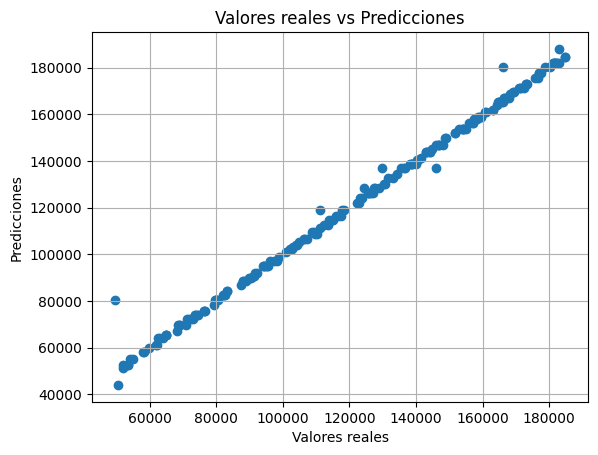

In [113]:
plt.scatter(y_test1, pred_test)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.grid(visible=True)
plt.show()

En este gráfico podemos notar que hay algunos valores que el modelo que el modelo no puede predecir correctamente, por lo cual vemos valores de residuos que se alejan de la recta. 

### Dataset 2 (70, 30)

In [114]:
tree_reg.fit(X_train4, y_train4)

,criterion,'squared_error'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [115]:
pred_train4 = tree_reg.predict(X_train4)

pred_test4 = tree_reg.predict(X_test4)

tableResult(y_test4, pred_test4)

,Actual,Predicted
206,159509.00490,158909.417231
780,144130.05170,143795.413543
417,80082.11902,79928.631336
870,50428.81124,42080.816160
988,83178.92524,84323.281386
...,...,...
318,96793.76682,97226.610367
611,154190.18690,153060.954043
800,174421.51510,174142.161837
363,91240.87291,92340.674474


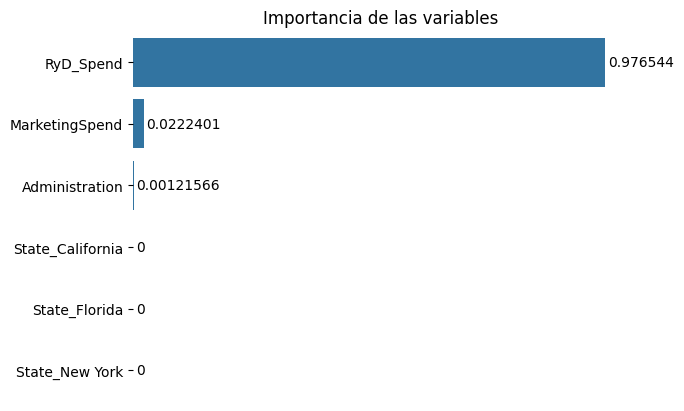

In [116]:
features_df = pd.DataFrame({'features': X_train4.columns, 'importances': tree_reg.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 3 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [117]:
rmse2 = np.sqrt(mean_squared_error(y_test4, pred_test4))

print('Error absoluto medio (MAE):', mean_absolute_error(y_test4, pred_test4))
print('Error medio cuadrado (MSE):', mean_squared_error(y_test4, pred_test4))
print('Raíz del error medio cuadrado (RMSE):', rmse2)
print("Porcentaje de error medio absoluto (MAPE):", np.mean(np.abs((y_test4 - pred_test4) / y_test4) * 100))

Error absoluto medio (MAE): 954.9828764187314
Error medio cuadrado (MSE): 7360253.176520517
Raíz del error medio cuadrado (RMSE): 2712.9786539006377
Porcentaje de error medio absoluto (MAPE): 1.0472388661546816


Entre las métricas del modelo podemos notar que en promedio la predicción se aleja por 2712 unidades sobre el precio real y la predicciones se desvían 954 unidades.

Cuando RMSE > MAE, significa que hay algunos errores grandes que están tirando el RMSE hacia arriba (outliers).

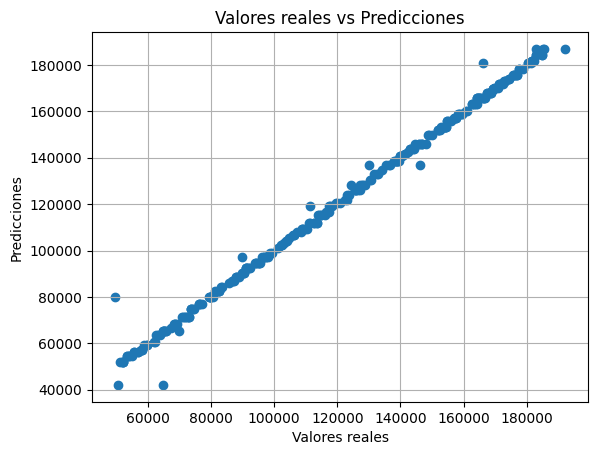

In [118]:
plt.scatter(y_test4, pred_test4)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.grid(visible=True)
plt.show()

La distribución de los residuos es similar al modelo entrenado con el split anterior de los datos, donde vemos algunos valores que no puede predecir correctamente.

# Segundo dataset

## Análisis exploratorio de datos (EDA)

In [119]:
dataset2 = pd.read_csv('drugType.csv')

In [120]:
#Creamos copia del dataset original
df2 = dataset2.copy()

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [121]:
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


In [122]:
df2.describe()

,Edad,Na_a_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


**Valores duplicados**

In [123]:
df2.duplicated().values.any()

False

**Valores faltantes**

In [124]:
df2.isna().sum()

Edad          0
Sexo          0
BP            0
Colesterol    0
Na_a_K        0
Droga         0
dtype: int64

**Codificación de variables categóricas**

In [125]:
# Convertir columnas categóricas en numéricas
df2 = pd.get_dummies(data=df2, columns=['Sexo', 'BP', 'Colesterol'])

cols_bool = ['Sexo_F', 'Sexo_M', 'BP_Alto', 'BP_Bajo', 'BP_Normal', 'Colesterol_Alto', 'Colesterol_Normal']
df2[cols_bool] = df2[cols_bool].astype('int')

df2.head()

,Edad,Na_a_K,Droga,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
0,23,25.355,DrogaY,1,0,1,0,0,1,0
1,47,13.093,DrogaC,0,1,0,1,0,1,0
2,47,10.114,DrogaC,0,1,0,1,0,1,0
3,28,7.798,DrogaX,1,0,0,0,1,1,0
4,61,18.043,DrogaY,1,0,0,1,0,1,0


**Análisis del balanceo del dataset**

In [126]:
conteo = df2['Droga'].value_counts()

df_balanceo = pd.DataFrame({
    'Conteo': conteo,
    'Frecuencia de aparición': conteo / conteo.sum() * 100
})

df_balanceo

,Conteo,Frecuencia de aparición
Droga,,
DrogaY,91,45.5
DrogaX,54,27.0
DrogaA,23,11.5
DrogaC,16,8.0
DrogaB,16,8.0


A partir de la tabla, se puede afirmar que el dataset está desbalanceado, ya que la clase DrogaY es ampliamente la más frecuente, seguida de DrogaX con 54 observaciones, mientras que las clases DrogaA, DrogaB y DrogaC aparecen significativamente menos, sumando entre ellas el 27,5% de frecuencia acumulada de aparición.

**División test - train**

In [127]:
X2 = df2.drop(columns=['Droga'])
y2 = df2['Droga']

In [128]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X2, y2, test_size=0.2, random_state=13, shuffle=True, stratify=y2)
X_train3, X_test3, y_train3, y_test3  = train_test_split(X2, y2, test_size=0.3, random_state=13, shuffle=True, stratify=y2)

**Escalado de datos**

In [129]:
X_train_scaled2 = X_train2.copy()
X_test_scaled2 = X_test2.copy()

scaler = StandardScaler()

X_train_scaled2[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train2[['Edad', 'Na_a_K']])
X_test_scaled2[['Edad', 'Na_a_K']] = scaler.transform(X_test2[['Edad', 'Na_a_K']])

X_train_scaled2.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
83,-0.362829,-0.665798,1,0,1,0,0,0,1
65,1.453207,1.522411,1,0,0,0,1,0,1
74,-0.786571,0.133419,0,1,1,0,0,0,1
7,-0.181225,-0.706016,0,1,0,1,0,1,0
80,0.968931,-0.302859,0,1,1,0,0,1,0


In [130]:
X_train_scaled3 = X_train3.copy()
X_test_scaled3 = X_test3.copy()

X_train_scaled3[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train3[['Edad', 'Na_a_K']])
X_test_scaled3[['Edad', 'Na_a_K']] = scaler.transform(X_test3[['Edad', 'Na_a_K']])

X_train_scaled3.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
39,-1.725205,-0.990332,0,1,0,0,1,1,0
129,-0.699477,-1.222585,1,0,0,0,1,1,0
71,-0.940825,0.540342,1,0,0,0,1,1,0
174,-0.096108,-0.458187,0,1,1,0,0,0,1
125,-1.483857,1.449988,1,0,1,0,0,0,1


**Distribuciones y correlaciones de las variables**

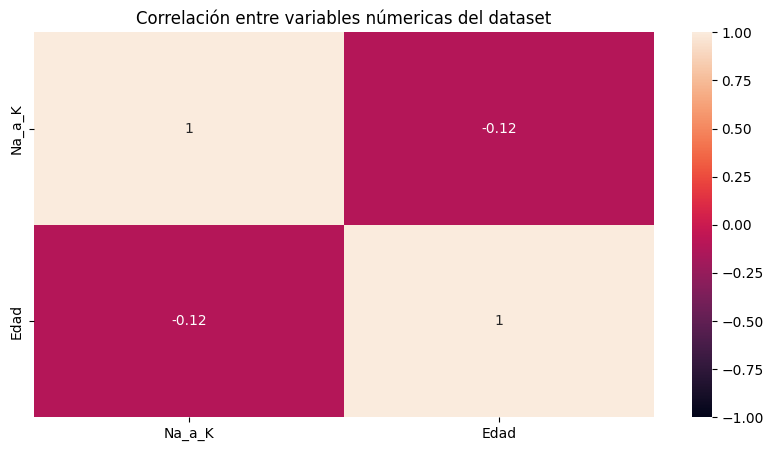

In [131]:
columnas_numericas2 = ['Na_a_K', 'Edad']

plt.figure(figsize=(10,5))
sns.heatmap(X_train2[columnas_numericas2].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

La correlación lineal entre Edad y Na_a_K es negativa y muy débil, lo que nos indica que no presentan una asociación significativa.

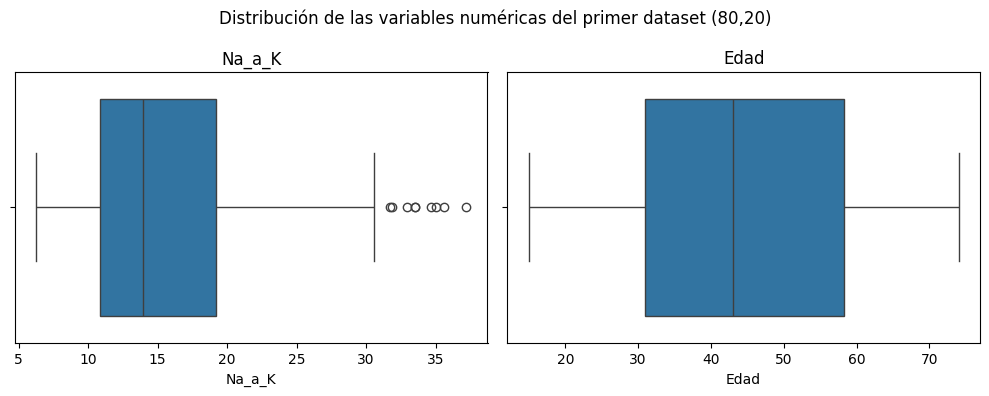

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas2):
    sns.boxplot(x=X_train2[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del primer dataset (80,20)')
plt.tight_layout()
plt.show()

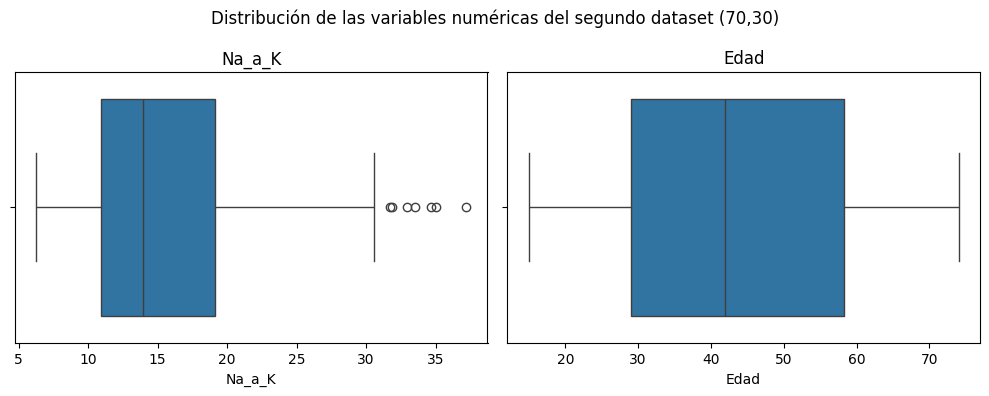

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas2):
    sns.boxplot(x=X_train3[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del segundo dataset (70,30)')
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que para la variable Edad no encontramos valores atípicos, mientras que para la variable Na_a_k si bien se encontraron valores atípicos, estos no son imposibles por lo cual no decidimos filtrarlos.

## Árbol de decisión

**Modelo base**

In [134]:
modelo_base = DecisionTreeClassifier(max_depth=None)

modelo_base.fit(X_train2, y_train2);

Definimos un modelo base dejando max_depth=None para que el árbol crezca completamente, para después compararlo con el modelo optimizado y analizar cómo se realiza la poda.

**Optimización de hiperparámetros**

In [135]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
    'criterion': ['entropy', 'log_loss', 'gini'],
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_grid, random_state=42)
random_search.fit(X_train2, y_train2)

# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_

print(f'{first_best_params}')

{'min_samples_split': 15, 'min_samples_leaf': 7, 'max_depth': 7, 'criterion': 'gini'}


**Mejor modelo**

In [136]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_clf = DecisionTreeClassifier(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13, 
                                  class_weight= 'balanced')

### Dataset 1: (80, 20)

In [137]:
tree_clf.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,15
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [138]:
pred_train = tree_clf.predict(X_train2)

pred_test2 = tree_clf.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Visualización**

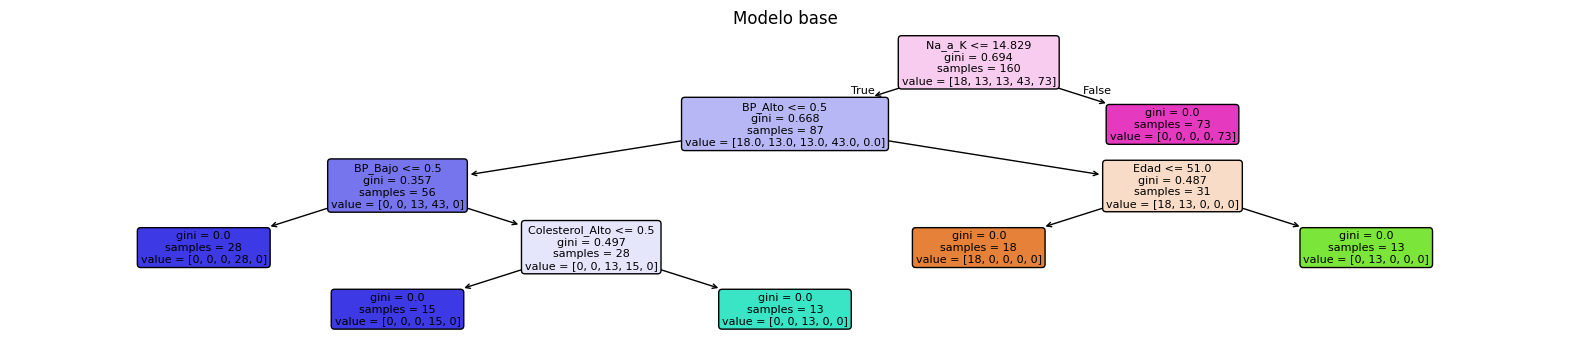

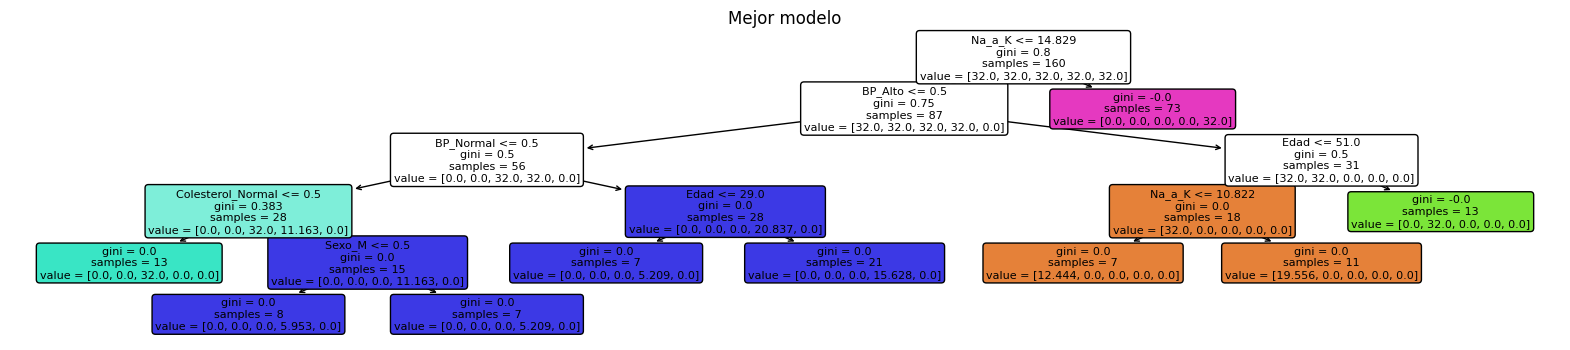

In [139]:
# Modelo base
plt.figure(figsize=(20,4))
plot_tree(modelo_base, feature_names=X_train2.columns, fontsize=8, filled=True, rounded=True)
plt.title('Modelo base')  
plt.show()

# Mejor modelo
plt.figure(figsize=(20,4))
plot_tree(tree_clf, feature_names=X_train2.columns, fontsize=8, filled=True, rounded=True)
plt.title('Mejor modelo')
plt.show()

In [140]:
# Obtenemos las profundidades de los árboles  
profundidad_modelo_base = modelo_base.get_depth()
profundidad_tree_clf = tree_clf.get_depth()

print(f'profundidad del modelo base: {profundidad_modelo_base}')
print(f'profundidad del mejor modelo: {profundidad_tree_clf}')

profundidad del modelo base: 4
profundidad del mejor modelo: 5


En este caso, el árbol de decisión del mejor modelo tiene mayor profundidad que el del árbol base. Esto se debe a que un árbol ligeramente más profundo puede capturar patrones más complejos, mejorando la predicción.

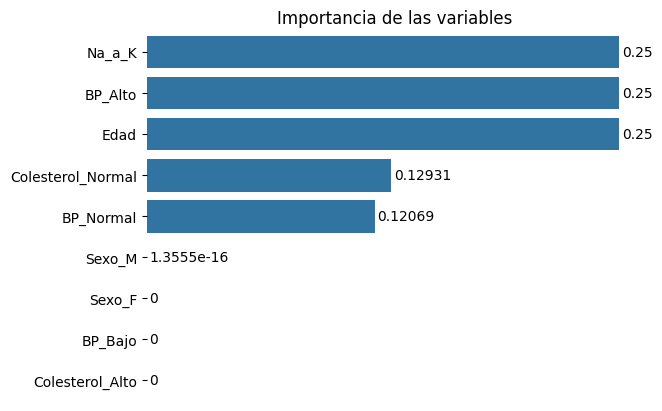

In [141]:
features_df = pd.DataFrame({'features': X_train2.columns, 'importances': tree_clf.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

A partir del gráfico podemos notar que sólo algunas de las variables del dataset contribuyen significativamente a las predicciones del modelo, entre ellas, las variables Na_a_K, BP_Alto y Edad, son igualmente de importantes, con el valor de importancia más alto (0.25). Las variables Colesterol_Normal y BP_Normal tienen un peso considerable, aunque menor. Por otro lado, se puede notar que el Sexo, BP_Bajo y Colesterol_Alto presentan una importancia cercana o igual a cero, lo que indica que no están siendo utilizadas por el modelo para tomar decisiones de predicción.

**Métricas**

In [142]:
f1_arbol1 = f1_score(y_test2, pred_test2, average='weighted')

print('Accuracy:', accuracy_score(y_test2, pred_test2))
print('Precisión:', precision_score(y_test2, pred_test2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_test2, average='weighted'))
print("F1:", f1_arbol1)

print('\nInforme de Clasificación:')
print(classification_report(y_test2, pred_test2))

Accuracy: 0.975
Precisión: 0.9791666666666667
Recall: 0.975
F1: 0.9736363636363636

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.83      1.00      0.91         5
      DrogaB       1.00      0.67      0.80         3
      DrogaC       1.00      1.00      1.00         3
      DrogaX       1.00      1.00      1.00        11
      DrogaY       1.00      1.00      1.00        18

    accuracy                           0.97        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.98      0.97      0.97        40



El modelo de árbol de decisión muestra un desempeño casi perfecto con un accuracy del 97.5%, logrando predecir correctamente la gran mayoría del tipo de droga. 
Además, la precisión ponderada  de 97.9% y el recall ponderado de 97.5% reflejan que, en promedio, el modelo acierta al clasificar correctamente las instancias asignadas a cada clase y además logra identificar casi todas las instancias reales de cada categoría. El F1-score de 97.4% confirma un balance sólido entre precisión y recall. 

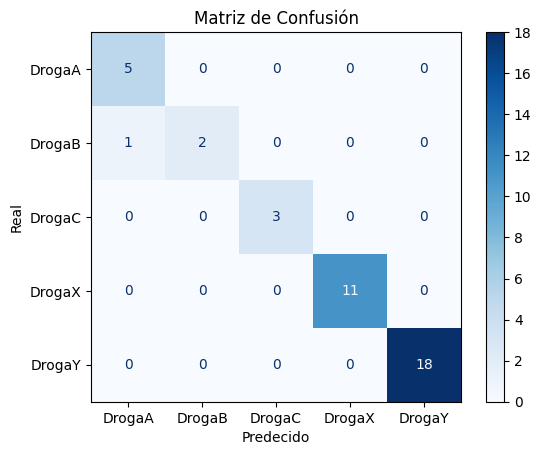

In [143]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_test2, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

La matriz de confusión muestra que el modelo logra muy buenos resultados a la hora de predecir las distintas clases ya que la mayoría de las predicciones se ubican sobre la diagonal principal, con un único error al predecir la droga A cuando era B.

### Dataset 2: (70, 30)

In [144]:
tree_clf.fit(X_train3, y_train3)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,15
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [145]:
pred_train3 = tree_clf.predict(X_train3)

pred_test3 = tree_clf.predict(X_test3)

tableResult(y_test3, pred_test3).head()

,Actual,Predicted
93,DrogaY,DrogaY
35,DrogaX,DrogaX
150,DrogaA,DrogaA
152,DrogaX,DrogaX
137,DrogaA,DrogaA


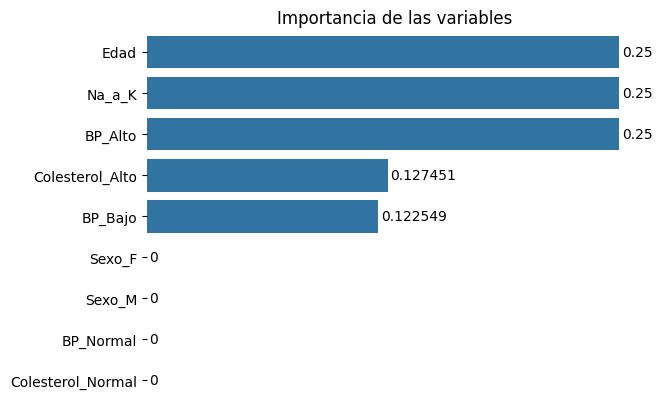

In [146]:
features_df = pd.DataFrame({'features': X_train3.columns, 'importances': tree_clf.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

Similar a la importancia que le dio el modelo entrenado con el dataset (80,20), las variables que influyen son Na_a_K, BP_Alto y Edad (con peso de 0.25), seguidas de Colesterol_Normal y BP_Normal.

**Métricas**

In [147]:
f1_arbol2 = f1_score(y_test3, pred_test3, average='weighted')

print('Accuracy:', accuracy_score(y_test3, pred_test3))
print('Precisión:', precision_score(y_test3, pred_test3, average='weighted'))
print('Recall:', recall_score(y_test3, pred_test3, average='weighted'))
print("F1:", f1_arbol2)

print('\nInforme de Clasificación:')
print(classification_report(y_test3, pred_test3))

Accuracy: 0.9833333333333333
Precisión: 0.9854166666666667
Recall: 0.9833333333333333
F1: 0.9829629629629629

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.88      1.00      0.93         7
      DrogaB       1.00      0.80      0.89         5
      DrogaC       1.00      1.00      1.00         5
      DrogaX       1.00      1.00      1.00        16
      DrogaY       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60



El segundo árbol de decisión muestra un desempeño ligeramente superior al primero, siendo un modelo más confiable con un accuracy de 98.3%, precisión de 98.5%, recall de 98.3% y F1 de 98.3%, obteniendo mejores métricas en todos los casos. Las clases minoritarias (DrogaA y DrogaB) mejoran respecto al primer árbol, aunque aún presentan leves desbalances entre precisión y recall, mientras que las clases más frecuentes (DrogaX y DrogaY) alcanzan 100% en todas las métricas. 

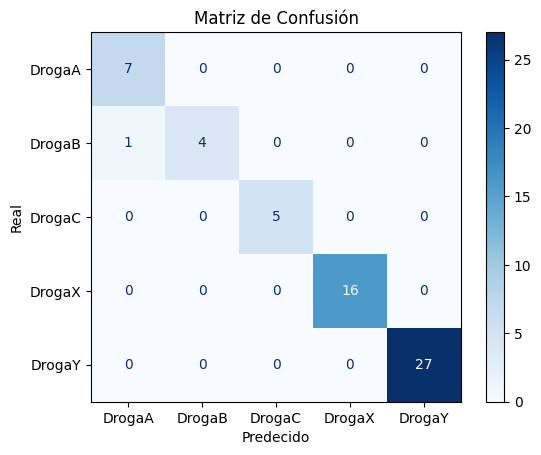

In [148]:
ConfusionMatrixDisplay.from_predictions(y_test3, pred_test3, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

Al igual que en la matriz de confusión anterior, se puede ver que el modelo logra muy buenos resultados a la hora de predecir las distintas clases, con una diagonal casi perfecta, y presenta el mismo error que antes confundiendo la droga A cuando era B.

## Multinomial Naïve Bayes

In [149]:
bayes1_test = X_test2.copy()
bayes1_train = X_train2.copy()

bayes2_test = X_test3.copy()
bayes2_train = X_train3.copy()

**Discretización de las variables númericas continuas**

In [150]:
bayes1_test['edad_menor25'] = (bayes1_test['Edad'] < 25).astype(int)
bayes1_test['edad_25_50'] = ((bayes1_test['Edad'] >= 25) & (bayes1_test['Edad'] < 50)).astype(int)
bayes1_test['edad_50_75'] = ((bayes1_test['Edad'] >= 50) & (bayes1_test['Edad'] < 75)).astype(int)
bayes1_test['edad_mayor75'] = (bayes1_test['Edad'] >= 75).astype(int)

bayes1_test['NaK_bajo'] = (bayes1_test['Na_a_K'] < 10).astype(int)
bayes1_test['NaK_medio'] = ((bayes1_test['Na_a_K'] >= 10) & (bayes1_test['Na_a_K'] < 20)).astype(int)
bayes1_test['NaK_alto'] = (bayes1_test['Na_a_K'] >= 20).astype(int)

In [151]:
bayes1_train['edad_menor25'] = (bayes1_train['Edad'] < 25).astype(int)
bayes1_train['edad_25_50'] = ((bayes1_train['Edad'] >= 25) & (bayes1_train['Edad'] < 50)).astype(int)
bayes1_train['edad_50_75'] = ((bayes1_train['Edad'] >= 50) & (bayes1_train['Edad'] < 75)).astype(int)
bayes1_train['edad_mayor75'] = (bayes1_train['Edad'] >= 75).astype(int)

bayes1_train['NaK_bajo'] = (bayes1_train['Na_a_K'] < 10).astype(int)
bayes1_train['NaK_medio'] = ((bayes1_train['Na_a_K'] >= 10) & (bayes1_train['Na_a_K'] < 20)).astype(int)
bayes1_train['NaK_alto'] = (bayes1_train['Na_a_K'] >= 20).astype(int)

In [152]:
bayes2_test['edad_menor25'] = (bayes2_test['Edad'] < 25).astype(int)
bayes2_test['edad_25_50'] = ((bayes2_test['Edad'] >= 25) & (bayes2_test['Edad'] < 50)).astype(int)
bayes2_test['edad_50_75'] = ((bayes2_test['Edad'] >= 50) & (bayes2_test['Edad'] < 75)).astype(int)
bayes2_test['edad_mayor75'] = (bayes2_test['Edad'] >= 75).astype(int)

bayes2_test['NaK_bajo'] = (bayes2_test['Na_a_K'] < 10).astype(int)
bayes2_test['NaK_medio'] = ((bayes2_test['Na_a_K'] >= 10) & (bayes2_test['Na_a_K'] < 20)).astype(int)
bayes2_test['NaK_alto'] = (bayes2_test['Na_a_K'] >= 20).astype(int)

In [153]:
bayes2_train['edad_menor25'] = (bayes2_train['Edad'] < 25).astype(int)
bayes2_train['edad_25_50'] = ((bayes2_train['Edad'] >= 25) & (bayes2_train['Edad'] < 50)).astype(int)
bayes2_train['edad_50_75'] = ((bayes2_train['Edad'] >= 50) & (bayes2_train['Edad'] < 75)).astype(int)
bayes2_train['edad_mayor75'] = (bayes2_train['Edad'] >= 75).astype(int)

bayes2_train['NaK_bajo'] = (bayes2_train['Na_a_K'] < 10).astype(int)
bayes2_train['NaK_medio'] = ((bayes2_train['Na_a_K'] >= 10) & (bayes2_train['Na_a_K'] < 20)).astype(int)
bayes2_train['NaK_alto'] = (bayes2_train['Na_a_K'] >= 20).astype(int)

In [154]:
bayes1_train.drop(columns=['Edad', 'Na_a_K'], inplace=True)
bayes2_train.drop(columns=['Edad', 'Na_a_K'], inplace=True)

bayes1_test.drop(columns=['Edad', 'Na_a_K'], inplace=True)
bayes2_test.drop(columns=['Edad', 'Na_a_K'], inplace=True)

**Modelo con el primer dataset**

In [155]:
clf_MNB = MultinomialNB()
clf_MNB.fit(bayes1_train, y_train2)

# Realizamos las predicciones
pred_MNB2 = clf_MNB.predict(bayes1_test)

print(classification_report(y_test2, pred_MNB2))

              precision    recall  f1-score   support

      DrogaA       0.75      0.60      0.67         5
      DrogaB       0.00      0.00      0.00         3
      DrogaC       0.67      0.67      0.67         3
      DrogaX       0.90      0.82      0.86        11
      DrogaY       0.68      0.83      0.75        18

    accuracy                           0.72        40
   macro avg       0.60      0.58      0.59        40
weighted avg       0.70      0.72      0.71        40



**Modelo con el segundo dataset**

In [156]:
clf_MNB = MultinomialNB()
clf_MNB.fit(bayes2_train, y_train3)

# Realizamos las predicciones
pred_MNB3 = clf_MNB.predict(bayes2_test)
print(classification_report(y_test3, pred_MNB3))

              precision    recall  f1-score   support

      DrogaA       0.67      0.29      0.40         7
      DrogaB       0.40      0.40      0.40         5
      DrogaC       0.67      0.40      0.50         5
      DrogaX       0.93      0.88      0.90        16
      DrogaY       0.65      0.81      0.72        27

    accuracy                           0.70        60
   macro avg       0.66      0.56      0.58        60
weighted avg       0.71      0.70      0.69        60



**Métricas de los modelos**

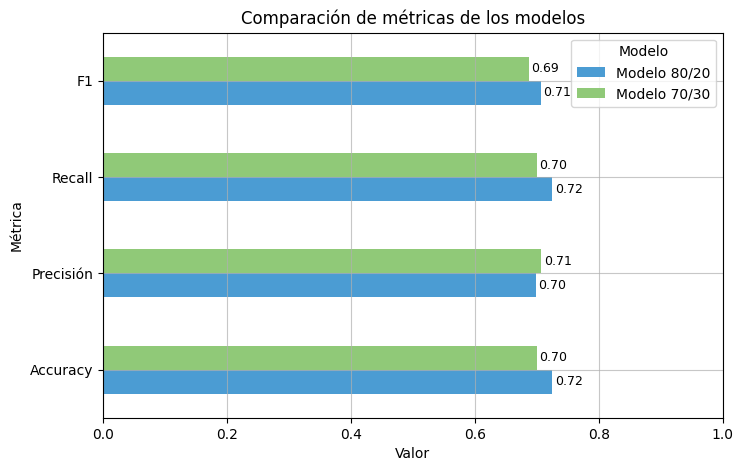

In [157]:
# Métricas del modelo 1 (80/20)
acc1 = accuracy_score(y_test2, pred_MNB2)
prec1 = precision_score(y_test2, pred_MNB2, average='weighted')
rec1  = recall_score(y_test2, pred_MNB2, average='weighted')
f1_bayes1   = f1_score(y_test2, pred_MNB2, average='weighted')

# Métricas del modelo 2 (70/30)
acc2 = accuracy_score(y_test3, pred_MNB3)
prec2 = precision_score(y_test3, pred_MNB3, average='weighted')
rec2  = recall_score(y_test3, pred_MNB3, average='weighted')
f1_bayes2   = f1_score(y_test3, pred_MNB3, average='weighted')

resultados = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precisión', 'Recall', 'F1'],
    'Modelo 80/20': [acc1, prec1, rec1, f1_bayes1],
    'Modelo 70/30': [acc2, prec2, rec2, f1_bayes2]
})

# Gráfico 
ax = resultados.plot(
    x='Métrica',
    kind='barh',
    figsize=(8,5),
    color=['#4B9CD3', '#90C978']
)

plt.title("Comparación de métricas de los modelos")
plt.xlabel("Valor")
plt.xlim(0, 1)
plt.legend(title="Modelo")
plt.grid(alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9)

plt.show()

Ambos modelos de Bayes presentan métricas muy similares, con valores de precisión, recall y F1-score entre 0.69 y 0.72, lo que indica un rendimiento estable y equilibrado. Esto sugiere que la variación en la proporción de entrenamiento y prueba (80/20 y 70/30) no afecta significativamente el desempeño del modelo, manteniendo una buena capacidad de predicción y generalización.

**Matriz de confusión de los modelos**

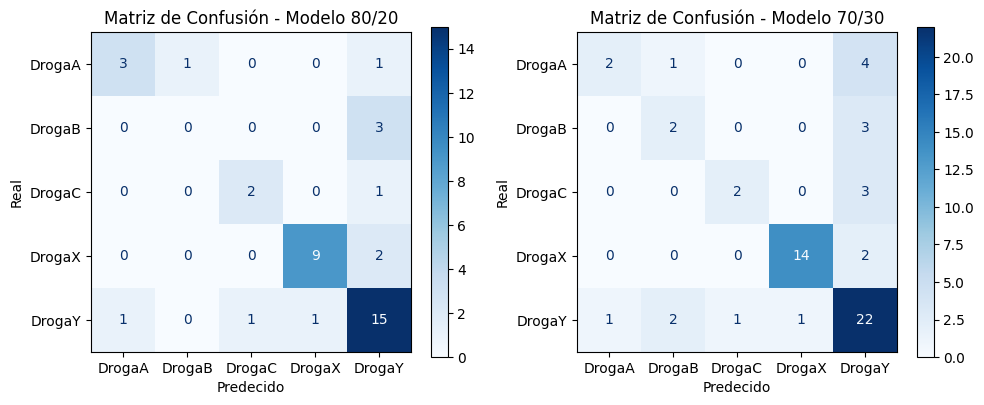

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de confusión - Modelo 80/20
ConfusionMatrixDisplay.from_predictions(y_test2, pred_MNB2, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Matriz de Confusión - Modelo 80/20")
axes[0].set_xlabel('Predecido')
axes[0].set_ylabel('Real')


# Matriz de confusión - Modelo 70/30
ConfusionMatrixDisplay.from_predictions(y_test3, pred_MNB3, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title("Matriz de Confusión - Modelo 70/30")
axes[1].set_xlabel('Predecido')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

A partir de la matriz de confusión de ambos modelos podemos notar el desbalance en la cantidad de apariciones de las Droga X e Y, en comparación de las Drogas A, B y C, lo cúal explica el bajo recall de las variables minoritarias. Además, se puede notar como ambos modelos suelen predecir la Droga Y incorrectamente en muchos casos.

## KNN

**Mejor modelo para el primer dataset**

In [159]:
# Definimos los parámetros de cantidad de vecinos, métrica y valor de p
parametros_grid = {'n_neighbors':  range(1, 50, 2),
                   'p':[1,2],
                   'metric': ['minkowski', 'euclidean', 'manhattan']}

grid_search1 = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [160]:
# Realizamos la búsqueda de los mejores hiperparámetros
grid_search1.fit(X_train_scaled2, y_train2)

print("Mejores hiperparámetros:", grid_search1.best_params_)

# Obtenemos el mejor modelo 
mejor_clasificador1 = grid_search1.best_estimator_

# Realizamos las predicciones 
pred_knn1 = mejor_clasificador1.predict(X_test_scaled2)

# Métricas
print('\nInforme de Clasificación:')
print(classification_report(y_test2, pred_knn1))

Mejores hiperparámetros: {'metric': 'minkowski', 'n_neighbors': 1, 'p': 2}

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.62      1.00      0.77         5
      DrogaB       0.67      0.67      0.67         3
      DrogaC       1.00      1.00      1.00         3
      DrogaX       1.00      0.91      0.95        11
      DrogaY       0.94      0.83      0.88        18

    accuracy                           0.88        40
   macro avg       0.85      0.88      0.85        40
weighted avg       0.90      0.88      0.88        40



**Mejor modelo para el segundo dataset**

In [161]:
# Definimos los parámetros de cantidad de vecinos, métrica y valor de p
parametros_grid = {'n_neighbors': range(1, 50, 2),
                   'p': [1,2],
                   'metric': ['minkowski', 'euclidean', 'manhattan']
                   }


grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [162]:
# Realizamos la búsqueda de los mejores hiperparámetros
grid_search.fit(X_train_scaled3, y_train3)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtenemos el mejor modelo 
mejor_clasificador = grid_search.best_estimator_

# Realizamos las predicciones 
pred_knn = mejor_clasificador.predict(X_test_scaled3)

# Métricas
print('\nInforme de Clasificación:')
print(classification_report(y_test3, pred_knn))

Mejores hiperparámetros: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 1}

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.78      1.00      0.88         7
      DrogaB       1.00      0.40      0.57         5
      DrogaC       1.00      0.60      0.75         5
      DrogaX       0.94      0.94      0.94        16
      DrogaY       0.90      1.00      0.95        27

    accuracy                           0.90        60
   macro avg       0.92      0.79      0.82        60
weighted avg       0.91      0.90      0.89        60



**Métricas**

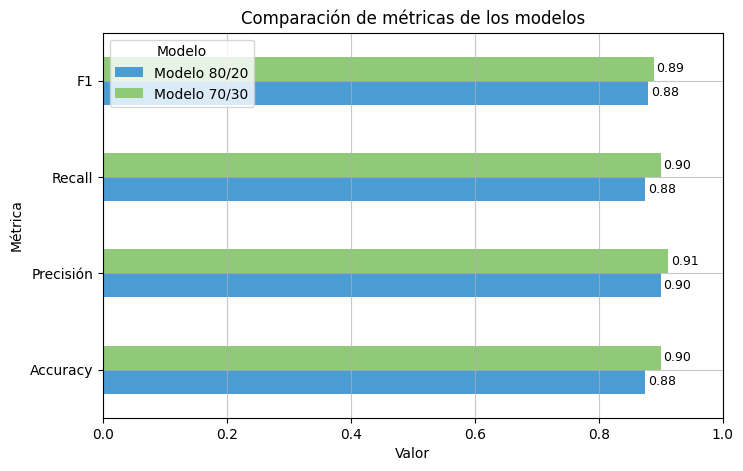

In [163]:
# Métricas del modelo 1 (80/20)
acc1 = accuracy_score(y_test2, pred_knn1)
prec1 = precision_score(y_test2, pred_knn1, average='weighted')
rec1  = recall_score(y_test2, pred_knn1, average='weighted')
f1_knn1   = f1_score(y_test2, pred_knn1, average='weighted')

# Métricas del modelo 2 (70/30)
acc2 = accuracy_score(y_test3, pred_knn)
prec2 = precision_score(y_test3, pred_knn, average='weighted')
rec2  = recall_score(y_test3, pred_knn, average='weighted')
f1_knn2   = f1_score(y_test3, pred_knn, average='weighted')

resultados = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precisión', 'Recall', 'F1'],
    'Modelo 80/20': [acc1, prec1, rec1, f1_knn1],
    'Modelo 70/30': [acc2, prec2, rec2, f1_knn2]
})


# Gráfico 
ax = resultados.plot(
    x='Métrica',
    kind='barh',
    figsize=(8,5),
    color=['#4B9CD3', '#90C978']
)

plt.title("Comparación de métricas de los modelos")
plt.xlabel("Valor")
plt.xlim(0, 1)
plt.legend(title="Modelo")
plt.grid(alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9)

plt.show()


La comparación entre los modelos entrenados muestra un rendimiento muy similar en todas las métricas. El modelo 80/20 presenta valores levemente superiores de exactitud, precisión, recall y F1, indicando una mejor capacidad general de predicción con una proporción de entrenamiento mayor.

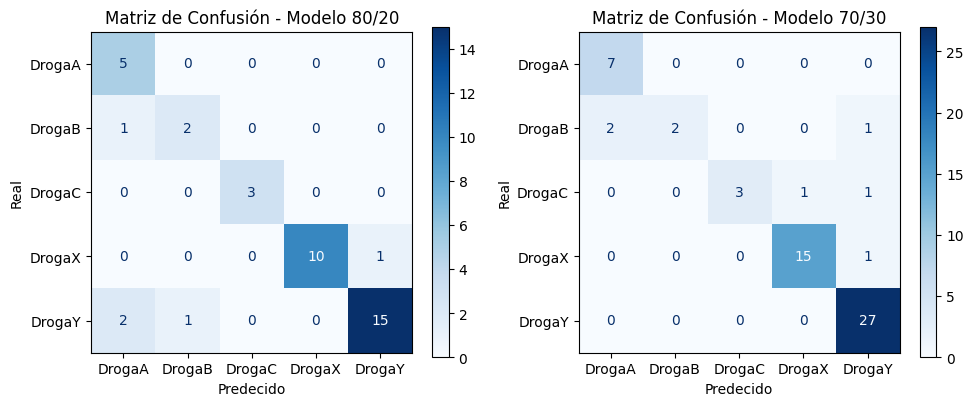

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de confusión - Modelo 80/20
ConfusionMatrixDisplay.from_predictions(y_test2, pred_knn1, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Matriz de Confusión - Modelo 80/20")
axes[0].set_xlabel('Predecido')
axes[0].set_ylabel('Real')


# Matriz de confusión - Modelo 70/30
ConfusionMatrixDisplay.from_predictions(y_test3, pred_knn, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title("Matriz de Confusión - Modelo 70/30")
axes[1].set_xlabel('Predecido')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

Al comparar ambas matrices de confusión, se observa que el modelo 80/20 tiende a sobrepredecir la clase “Droga A”, mientras que el modelo 70/30 muestra una mayor inclinación a clasificar erróneamente hacia “Droga Y”. En conjunto, ambos modelos mantienen un buen nivel de acierto general, aunque con sesgos de predicción distintos.

# Conclusión

**Dataset 1**

El primer dataset utilizado corresponde a un conjunto de registros con distintas características (RyD_Spend, Administration, MarketingSpend, State, Profit) a partir de las cuales se busca predecir el valor de profit. Este conjunto fue dividido en diferentes tamaños de entrenamiento y prueba (70/30 y 80/20), para comparar el rendimiento del árbol de regresión.

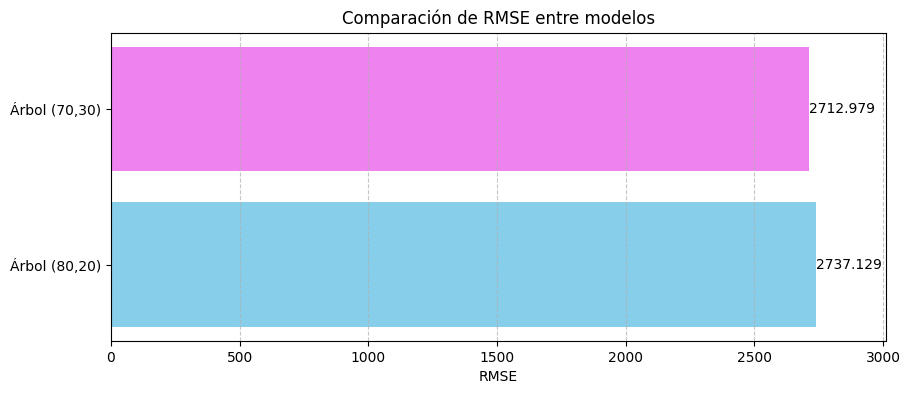

In [165]:
valores_rmse = [rmse1, rmse2]
lista_rmse = ['Árbol (80,20)', 'Árbol (70,30)']

hue = ['skyblue', 'violet']

plt.figure(figsize=(10,4))
bars = plt.barh(lista_rmse, valores_rmse, color=hue) 
plt.xlabel('RMSE')
plt.title('Comparación de RMSE entre modelos')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, max(valores_rmse)*1.1)  

for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.show()

Para la comparación general entre los modelos se utilizó el RMSE, ya que nos permite realizar una comparación en unidades de los valores reales, por lo cual es fácil de interpretar la magnitud del error y facilita la comparación.


Ambos modelos mostraron un rendimiento muy similar, con RMSE cercanos, lo que indica que sus predicciones se desvían en promedio por $2700. El modelo entrenado con el dataset (70/30) tiene un RMSE ligeramente menor que el modelo 80/20, lo que sugiere que en este caso una mayor proporción de datos de prueba no degradó significativamente la capacidad predictiva.

**Dataset 2**

El dataset utilizado corresponde a un conjunto de registros con distintas características (Edad,Sexo,BP,Colesterol,Na_a_K) a partir de las cuales se busca predecir el tipo de Droga consumida. Esta variable objetivo no presenta una distribución uniforme, es decir, que algunos tipos de drogas presentan una cantidad significativamente mayor a comparación de otras, por lo cual podemos concluir que se trata de un dataset desbalanceado. Este conjunto fue dividido en diferentes tamaños de entrenamiento y prueba (70/30 y 80/20), para comparar el rendimiento de los modelos KNN, Naive Bayes y Árbol de Decisión.

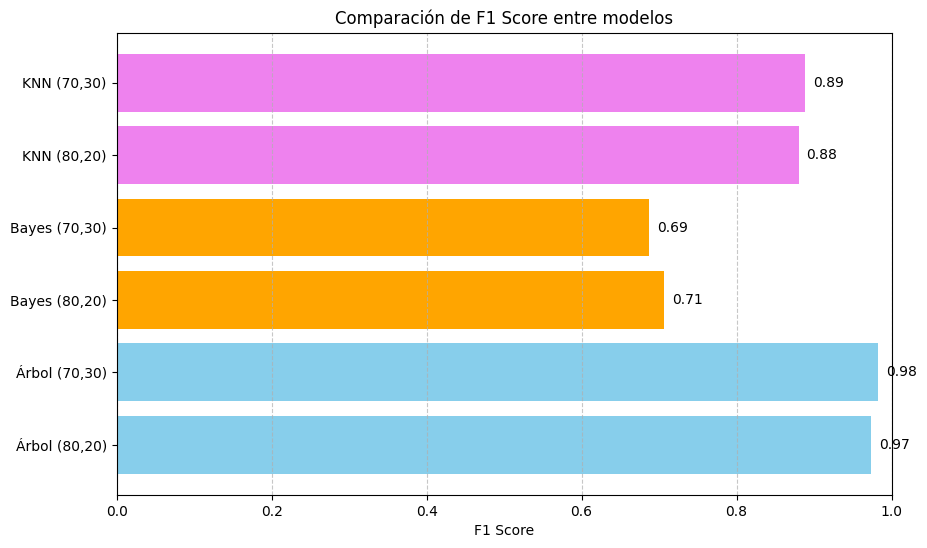

In [166]:
valores_f1 = [f1_arbol1, f1_arbol2, f1_bayes1, f1_bayes2, f1_knn1, f1_knn2]
lista_f1 = ['Árbol (80,20)', 'Árbol (70,30)', 'Bayes (80,20)', 'Bayes (70,30)', 'KNN (80,20)', 'KNN (70,30)']

colores = ['skyblue', 'skyblue', 'orange', 'orange', 'violet', 'violet']

plt.figure(figsize=(10,6))
bars = plt.barh(lista_f1, valores_f1, color=colores)
plt.xlim(0, 1)
plt.xlabel('F1 Score')
plt.title('Comparación de F1 Score entre modelos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', va='center')

plt.show()

Para la comparación general entre los modelos se utilizó el F1-Score, ya que es una métrica que combina precisión y recall, permitiéndonos comparar sin desfavorecer a las clases minoritarias porque pondera según la frecuencia de aparición de cada clase.

En cuanto a los resultados, el modelo Árbol de Decisión entrenado con el split (70,30) fue el que alcanzó el mejor desempeño global con un F1 de 0.98, seguido del árbol entrenado con el (80,20) que dió un F1 de 0.97. Esto quiere decir que ambos modelos demostraron una excelente capacidad de generalización. Por otro lado, el modelo KNN también mostró resultados consistentes, aunque ligeramente inferiores, manteniendo valores de F1 altos y estables entre los dos escenarios, obteniendo mejores métricas con el dataset de (70,30). Por último, Naive Bayes obtuvo los puntajes más bajos, lo que sugiere una menor adaptación al tipo de datos del conjunto, denotando que no pudo interpretar las variables discretizadas.

En conclusión, el Árbol de Decisión se posiciona como el modelo más preciso y robusto para este problema, mientras que ambos esquemas de división (70/30 y 80/20) presentaron un comportamiento similar, sin afectar significativamente el rendimiento final.